In [1]:
import os
from scipy import ndimage, misc
from matplotlib import pyplot as plt
import numpy as np
import imageio
from sklearn.datasets import load_boston, load_digits, load_iris, load_wine
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import cv2
from sklearn.svm import SVR
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
rcParams['figure.figsize'] = 20,20

In [2]:
## Implement SVD

def SVD(X):
  num_of_dims = len(X.shape)
  if num_of_dims==3:
    X = np.transpose(X,(2,0,1))
    U,S,V = np.linalg.svd(X,full_matrices=False)
  else:
    U,S,V = np.linalg.svd(X,full_matrices=False)
  return U,S,V

In [3]:
def rebuildsvd(U, S, V, k):
    
    number_of_dimensions = len(U.shape) ## Get the number of dimensions to decide if it is 2D or 3D
    
    if number_of_dimensions ==3:
        Sigma_new = np.zeros((3, U.shape[1], V.shape[1])) ## Create an empty matrix with size N*D
        for j in range(3):
            np.fill_diagonal(Sigma_new[j, :k, :], S[j, :k]) ## Fid the new matrix diagonal with S
        Xrebuild = np.matmul(U,np.matmul(Sigma_new,V)) ## Perform Matrix Multiplication ( equation in the source)
        Xrebuild = np.transpose(Xrebuild, (0,1,2)) ## Transpose the matrix again to be of size N*D*3
        
    else:
        Xrebuild = np.matrix(U[:, :k]) * np.diag(S[:k]) *np.matrix(V[:k, :]) ## Formula
    return Xrebuild

In [4]:
def compression_ratio(X, k):
    
    N = X.shape[0]

    compression_ratio = N/(2*k+1) 

    return compression_ratio

In [5]:
def recovered_variance_proportion(S, k):
    number_of_dim = len(S.shape)

    if number_of_dim==1: ## 2D Image
        
        eigenval = S**2/(S.shape[0]-1)  
        significance = [np.abs(i)/np.sum(eigenval) for i in eigenval] ## Get the importance of each eigenvalue
        significance.sort(reverse =True) ## Sort them in a descending order
        recovered_var = sum(significance[0:k]) ## Add them till the k-th componenet
        ## OR
        """
        explained_variance = S**2/(S.shape[0]-1)
        total_var = explained_variance.sum()
        recovered_var = explained_variance / total_var
        explained_variance = explained_variance[:k]
        recovered_var = np.around(np.sum(recovered_var[:k]),decimals = 3)

        """

    else:
        recovered_var = []
        for i in range(3): ## Same as 2D but repeat 3 times, one for each dimension.
            current_eigen_val = S[i,:]**2/(S.shape[1]-1) 
            current_significance = [np.abs(i)/np.sum(current_eigen_val) for i in current_eigen_val]
            current_significance.sort(reverse=True)
            current_recovered_var = sum(current_significance[0:k])
            recovered_var.append(current_recovered_var)

    return recovered_var

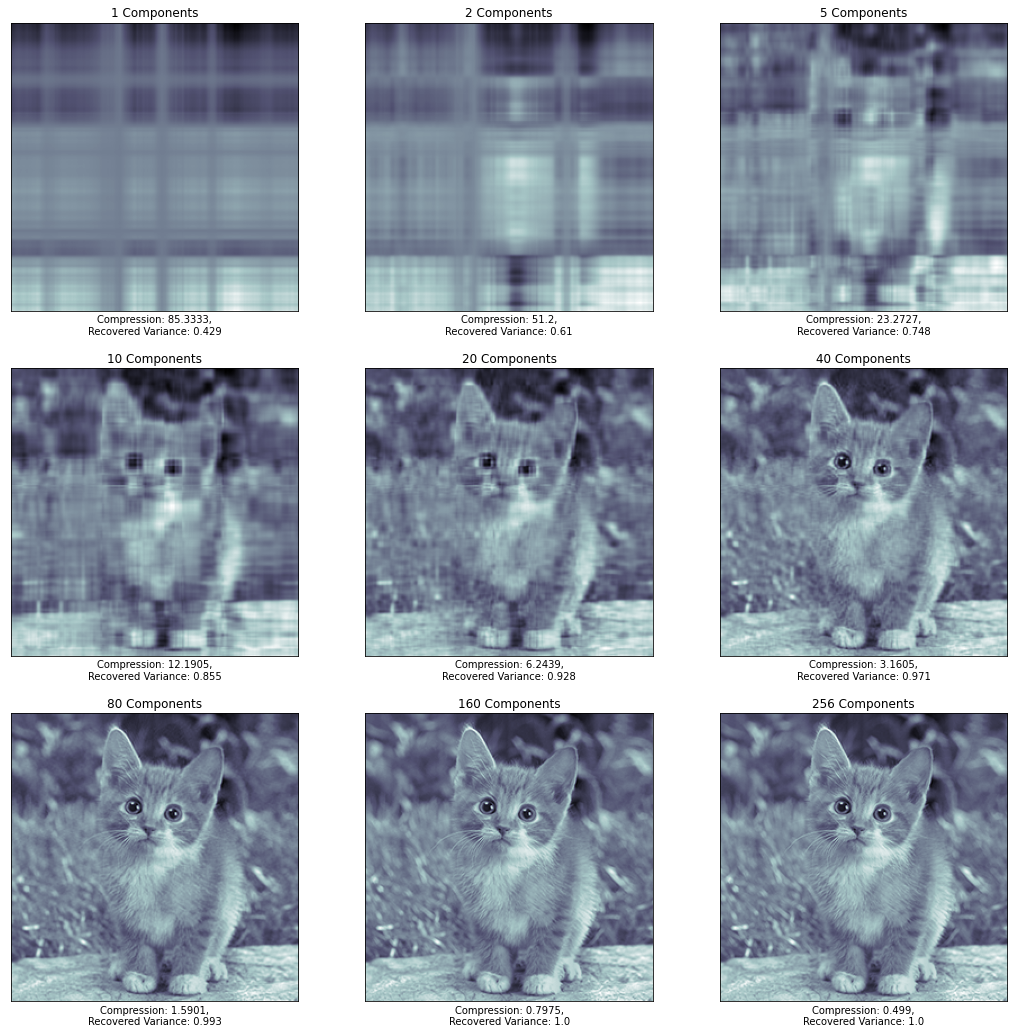

In [8]:
img = plt.imread("cat.png")
import cv2
bw_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

bw_image_mean = np.mean(bw_image,axis=0)
bw_image -= bw_image_mean

U, S, V = SVD(bw_image)
component_num = [1,2,5,10,20,40,80,160,256]
fig = plt.figure(figsize=(18, 18))

# plot several images
i=0
for k in component_num:
    img_rebuild = rebuildsvd(U, S, V, k)
    c = np.around(compression_ratio(bw_image, k), 4)
    r = np.around(recovered_variance_proportion(S, k), 3)
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(img_rebuild, cmap=plt.cm.bone)
    ax.set_title(f"{k} Components")
    ax.set_xlabel(f"Compression: {c},\nRecovered Variance: {r}")
    i = i+1
    

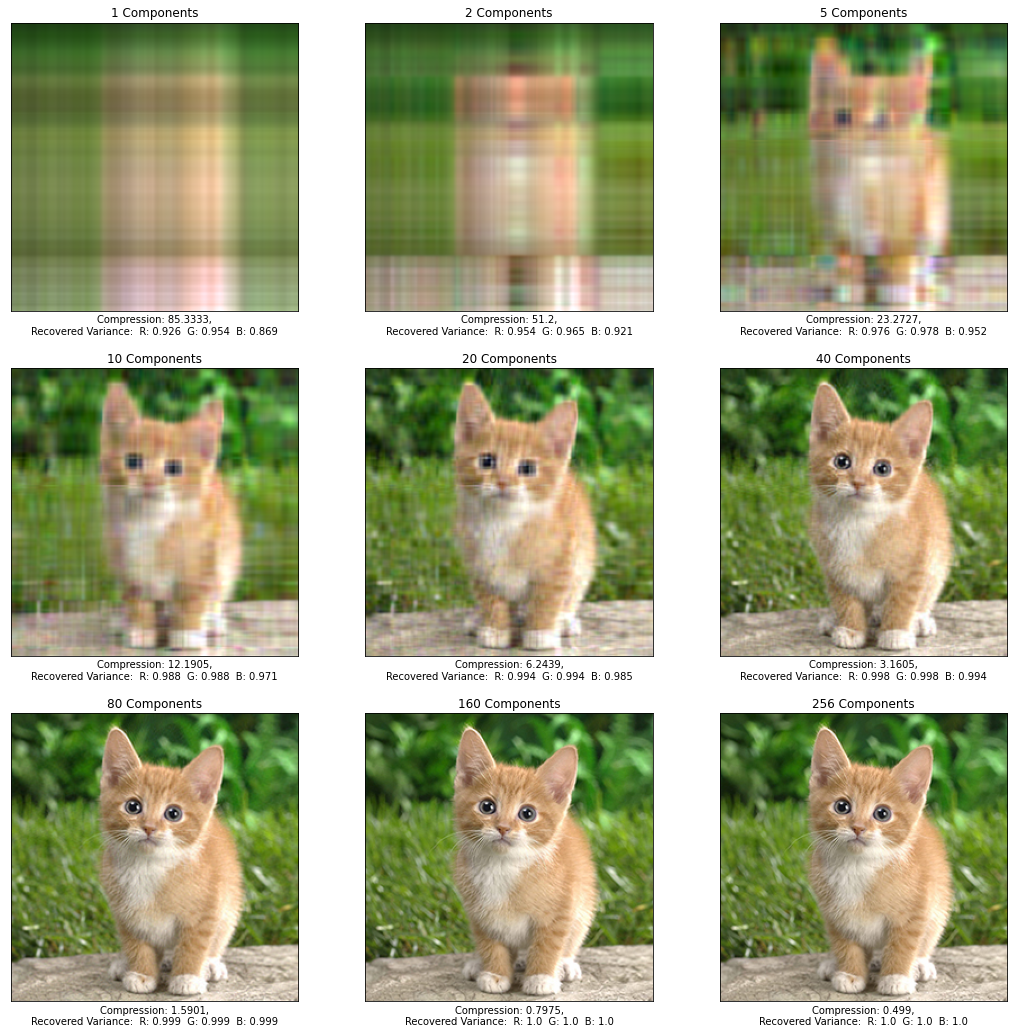

In [9]:
#helper do not need to change

U, S, V = SVD(img)
component_num = [1,2,5,10,20,40,80,160,256]

fig = plt.figure(figsize=(18, 18))

# plot several images
i=0
for k in component_num:
    img_rebuild = rebuildsvd(U, S, V, k)
    img_rebuild = np.transpose(img_rebuild, (1, 2, 0))
    c = np.around(compression_ratio(img_rebuild, k), 4)
    r = np.around(recovered_variance_proportion(S, k), 3)
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(img_rebuild)
    ax.set_title(f"{k} Components")
    ax.set_xlabel(f"Compression: {np.around(c,4)},\nRecovered Variance:  R: {r[0]}  G: {r[1]}  B: {r[2]}")
    i = i+1

In [10]:
img = plt.imread("cat.png")
import cv2
bw_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

pca_sklearn = PCA(1).fit(bw_image) 
img_transformed = pca_sklearn.transform(bw_image) 
print(img_transformed.shape) 
print(np.sum(pca_sklearn.explained_variance_ratio_) )

(256, 1)
0.4292149


In [11]:
def pca(X):
    mean = (np.mean(X,axis = 0)) ## Center the data ( VERY IMPORTANT)
    mean = mean.astype('int') ## Avoid type cast errors
    X -= mean ## Subtract the mean
    U,S,V = SVD(X) ## Perform SVD
    return U,S,V

In [12]:
def intrinsic_dimension(S, recovered_variance=.98):
    eigenval = S**2/(S.shape[0]-1)
    significance = [np.abs(i)/np.sum(eigenval) for i in eigenval]
    significance.sort(reverse =True)
    
    total_var = 0 
    dim = 0
    i = 0
    while total_var <= recovered_variance: ## Loop over the significance util met the required variance
        total_var += significance[dim]
        dim +=1
    i +=1
    return dim

In [13]:
def num_linearly_ind_features(S, eps=1e-11):
    eigenval = S**2/(S.shape[0]-1)
    dim = len([i for i in eigenval if i >= eps]) ## Find all eigen values that have more than the threshold
    return dim

In [14]:
data_boston=load_boston(return_X_y=True)
X=data_boston[0]
y=data_boston[1]
X.shape

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

(506, 13)

In [15]:
#apply PCA on the dataset and also find the number of linearly independent and intrinsic components 
def apply_PCA_on_data(X):
    U,S,V = pca(X)
    intrinsic_dimensions = intrinsic_dimension(S) ## call functions 
    independent_features = num_linearly_ind_features (S)
    x_pca = U[:, :intrinsic_dimensions] * S[:intrinsic_dimensions]
    return x_pca, independent_features , intrinsic_dimensions

In [16]:
X_PCA, ind_features, intrinsic_dimensions = apply_PCA_on_data(X)
print("data shape with PCA ",X_PCA.shape)
print("Number of independent features ",ind_features)
print("Number of intrinsic components ",intrinsic_dimensions)


data shape with PCA  (506, 3)
Number of independent features  13
Number of intrinsic components  3


In [17]:
#get training and testing data 
X_train , X_test , y_train, y_test = train_test_split(X_PCA,y , test_size = 0.2 , random_state=42)

In [18]:
#use SVR for getting predcited labels
clf = SVR()
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
#calculate MSE 
mse_score = mean_squared_error(y_pred, y_test)
print("MSE score with PCA",mse_score)

MSE score with PCA 51.2001178209075


In [19]:
#Ridge regression without PCA
#get training and testing data 
X_train , X_test , y_train, y_test = train_test_split(X ,y , test_size = 0.2 , random_state=42)
#use Ridge Regression for getting predcited labels
clf = SVR()
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
#calculate RMSE 
rmse_score = mean_squared_error(y_pred, y_test)
print("MSE score without PCA",rmse_score)

MSE score without PCA 49.37799345969089


In [20]:
def visualize(X,y):
    U,S,V = pca(X) ## Perform PCA
    eigenval = S**2/(X.shape[0]-1) ## Same as before
    significance = [np.abs(i)/np.sum(eigenval) for i in eigenval]
    significance.sort(reverse =True)
    recovered_var = sum(significance[0:2]) ## Till second dimension as we want to visualize it !
    
    reduced_data = U[:, :2] * S[:2]  ## The restored data
    colors = ['r','b','y']
    plt.figure(figsize=(8,5))
    for color, i in zip(colors, [0, 1, 2]):
        plt.scatter(reduced_data[y == i, 0], reduced_data[y == i, 1],marker='x', color=color, alpha=.8,lw=2)
    plt.show()
    return recovered_var

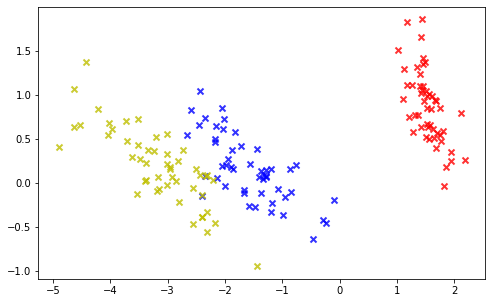

Retained variance for iris dataset  0.9774907426943391


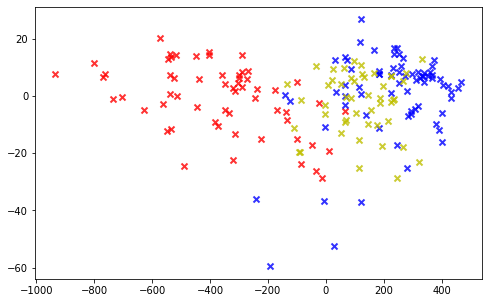

Retained variance for wine dataset  0.9998036218658357


In [21]:
data_iris=load_iris(return_X_y=True)
X=data_iris[0]
y=data_iris[1]
retained_variance_for_iris=visualize(X,y)
print("Retained variance for iris dataset ",retained_variance_for_iris)

data_wine=load_wine(return_X_y=True)
X=data_wine[0]
y=data_wine[1]
retained_variance_for_wine=visualize(X,y)
print("Retained variance for wine dataset ",retained_variance_for_wine)

0.28509364823697514


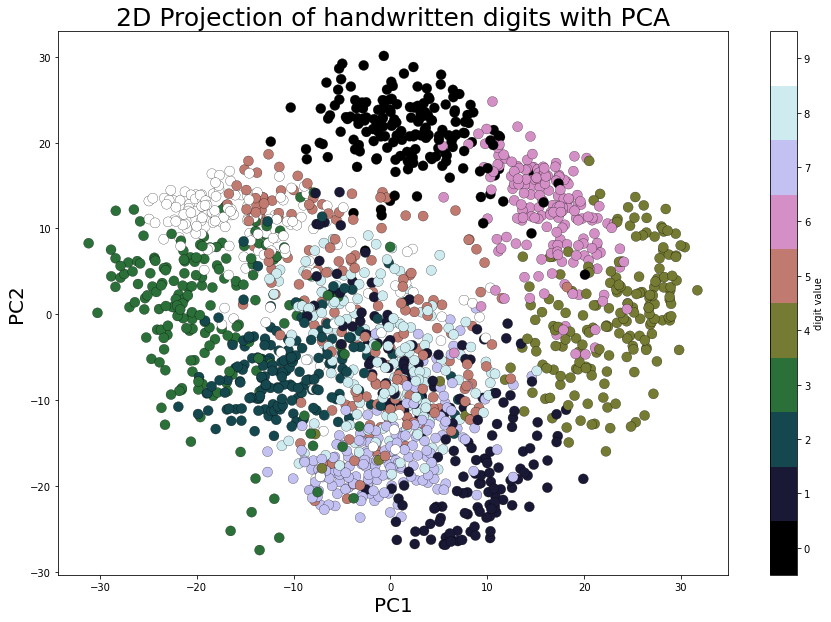

In [22]:
digits = load_digits() 

pca_digits=PCA(2)
digits.data_proj = pca_digits.fit_transform(digits.data) 
print(np.sum(pca_digits.explained_variance_ratio_))
plt.figure(figsize=(15,10))
plt.scatter(digits.data_proj[:, 0], digits.data_proj[:, 1], lw=0.25, c=digits.target, edgecolor='k',  s=100, cmap=plt.cm.get_cmap('cubehelix', 10))
plt.xlabel('PC1', size=20), plt.ylabel('PC2', size=20), plt.title('2D Projection of handwritten digits with PCA', size=25)
plt.colorbar(ticks=range(10), label='digit value')
plt.clim(-0.5, 9.5)

In [23]:
df = pd.read_csv("USArrests.csv")
names = df['Unnamed: 0']
df.drop(labels="Unnamed: 0",axis=1,inplace=True)
X = df

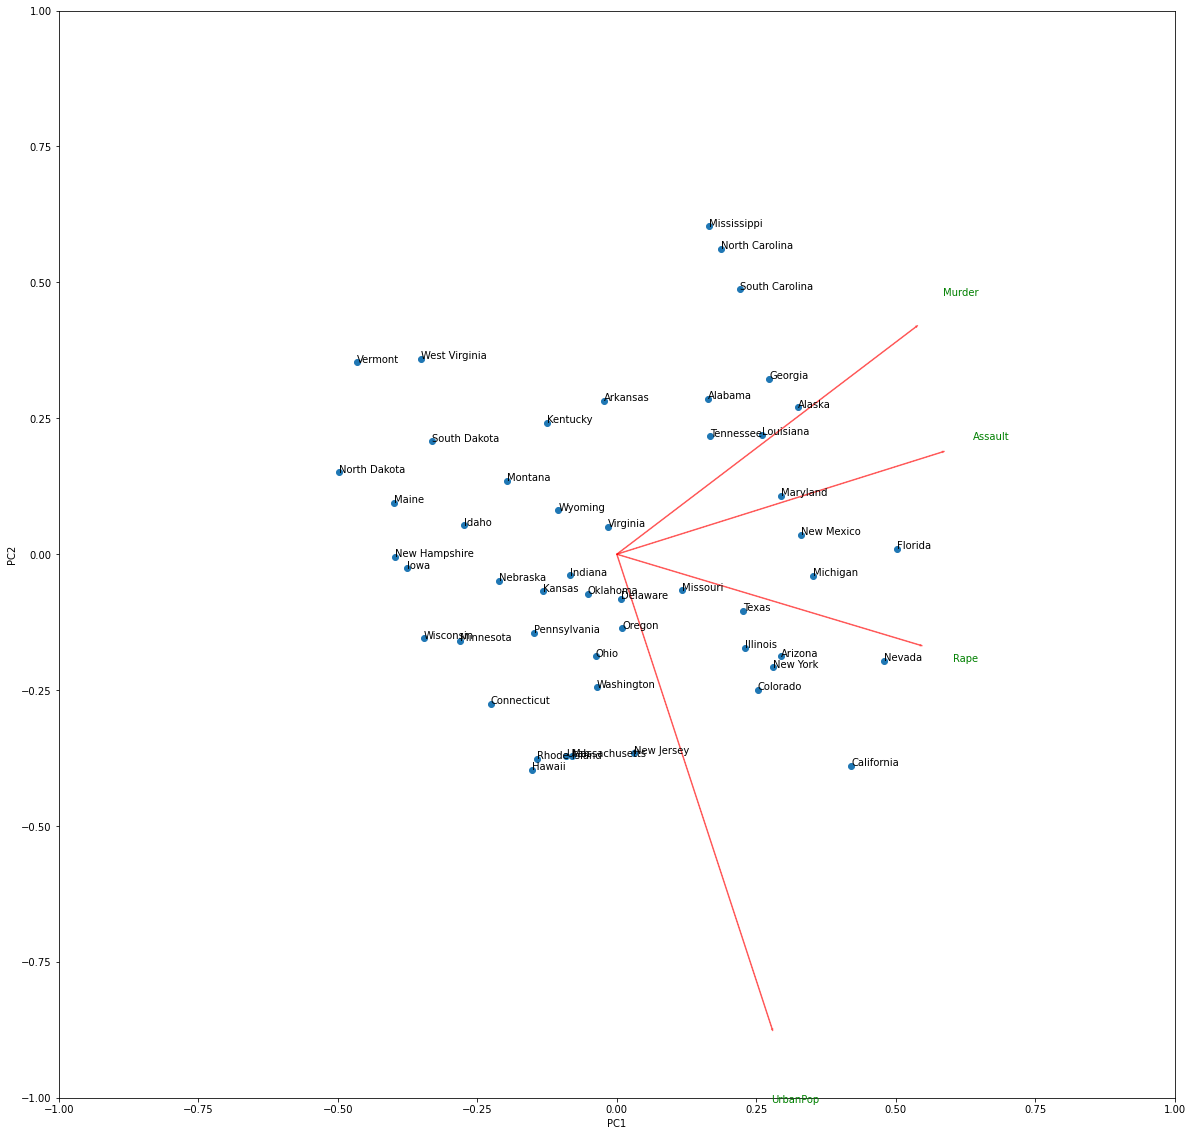

In [24]:
# In general, it's a good idea to scale the data prior to PCA.
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)    
pca_sklearn = PCA()
x_new = pca_sklearn.fit_transform(X)

def biplot(score,coeff,names,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    fig, ax = plt.subplots()

    ax.scatter(xs * scalex,ys * scaley)
    for i, txt in enumerate(names):
        ax.annotate(txt, (xs[i] * scalex, ys[i] * scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_xlabel("PC{}".format(1))
    ax.set_ylabel("PC{}".format(2))

#Call the function. Use only the 2 PCs.
biplot(x_new[:,0:2],np.transpose(pca_sklearn.components_[0:2, :]),names,labels = list(df.columns))
plt.show()

In [25]:
def randomly_perturb_data(data, multiplier=1000):
    D = data.shape[1] 
    random_col = np.random.randint(D)  ## Choose random index
    perturbed_data = data
    perturbed_data[:,random_col] = perturbed_data[:,random_col]*multiplier ## mutliply the values in this index by a multiplier
    return perturbed_data
   
def scree_plot(X, n_components=10):
    """
    Plot proportion of variance contained in each individual component
    """
    U,S,V = pca(X)
    eigenval = S**2/(X.shape[0]-1)
    significance = [np.abs(i)/np.sum(eigenval) for i in eigenval]
    significance.sort(reverse =True)    
    fig = plt.figure(figsize=(8,5))
    plt.plot(list(range(1,len(significance)+1)),np.cumsum(significance))

    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.show()
    
def plot_component_vector(X):
    U,S,V = pca(X)
    eigenval = S**2/(X.shape[0]-1)
    significance = [np.abs(i)/np.sum(eigenval) for i in eigenval]
    significance.sort(reverse =True)    
    fig = plt.figure(figsize=(8,5))
    plt.bar(list(range(len(significance))),significance)
    plt.title('Component Vector Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.show()

In [26]:
data_iris=load_iris(return_X_y=True)
X_iris=data_iris[0]
y_iris=data_iris[1]
data_wine = load_wine(return_X_y=True)
X_wine = data_wine[0]
y_wine = data_wine[1]
data_boston=load_boston(return_X_y=True)
X_boston=data_boston[0]
y_boston=data_boston[1]

data_iris_m=load_iris(return_X_y=True)
X_iris_m=data_iris_m[0]
y_iris_m=data_iris_m[1]
data_wine_m = load_wine(return_X_y=True)
X_wine_m = data_wine_m[0]
y_wine_m = data_wine_m[1]
data_boston_m=load_boston(return_X_y=True)
X_boston_m=data_boston[0]
y_boston_m=data_boston[1]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

Independent Features and Intrinsic Dimensions with no Multiplication for Iris dataset  4 3
Independent Features and Intrinsic Dimensions after Multiplication for Iris dataset    4 1

Scree plot and Component Vector with No Multiplication


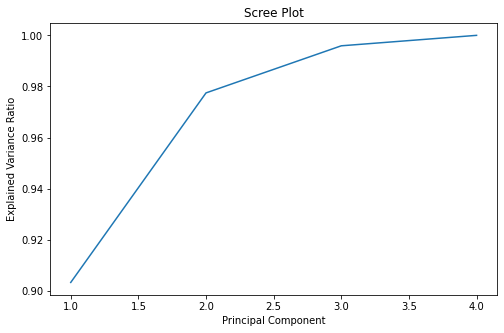

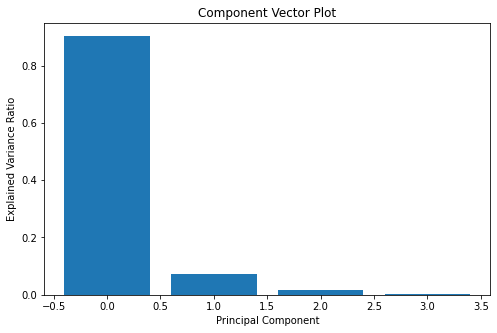

Scree plot and Component Vector with Multiplication


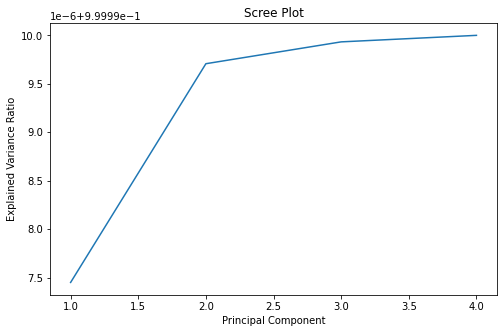

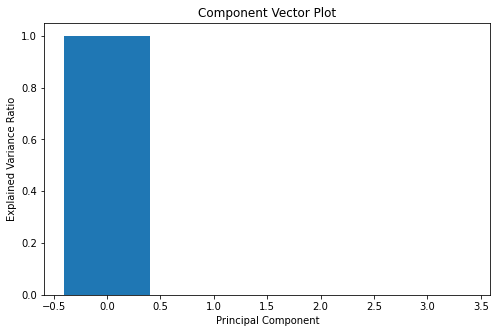

In [27]:
_, ind_features_iris, intrinsic_dimensions_iris = apply_PCA_on_data(X_iris)
X_iris_m = randomly_perturb_data(X_iris_m)
_, ind_features_iris_m, intrinsic_dimensions_iris_m = apply_PCA_on_data(X_iris_m)
print("Independent Features and Intrinsic Dimensions with no Multiplication for Iris dataset ",ind_features_iris,intrinsic_dimensions_iris)
print("Independent Features and Intrinsic Dimensions after Multiplication for Iris dataset   ",ind_features_iris_m,intrinsic_dimensions_iris_m)
print("\nScree plot and Component Vector with No Multiplication")
scree_plot(X_iris)
plot_component_vector(X_iris)
print("Scree plot and Component Vector with Multiplication")
scree_plot(X_iris_m)
plot_component_vector(X_iris_m)